<AxesSubplot:>

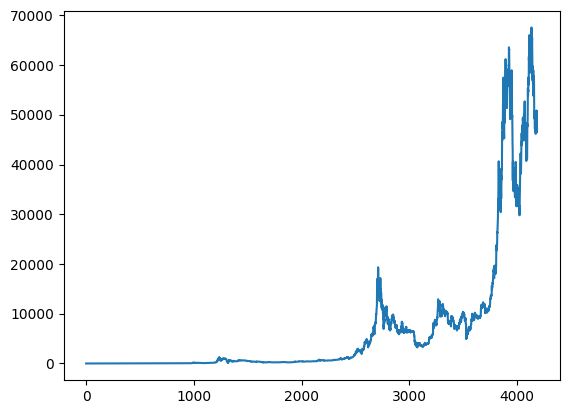

In [1]:
from _preprocessing import CryptoCompareReader
test_reader = CryptoCompareReader('btc', '../splits/test', drop_na_subset=['close'], add_time_columns=True,
                                  drop_last=True)
train_reader = CryptoCompareReader('btc', '../splits/train', drop_na_subset=['close'], add_time_columns=True,
                                   drop_last=True)

test_df = test_reader.read()[['time','close']]
train_data = train_reader.read()[['time','close']]

train_data['close'].plot()

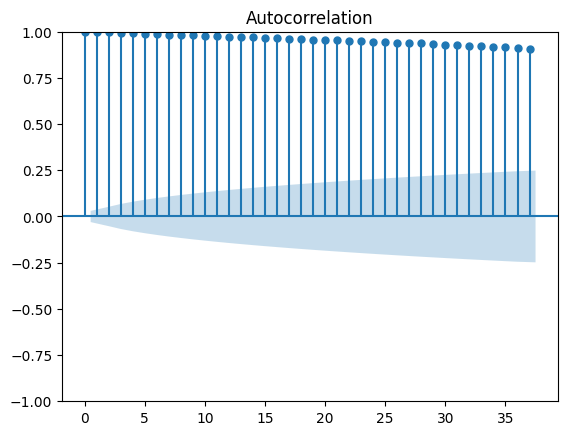

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_data['close'].values);

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


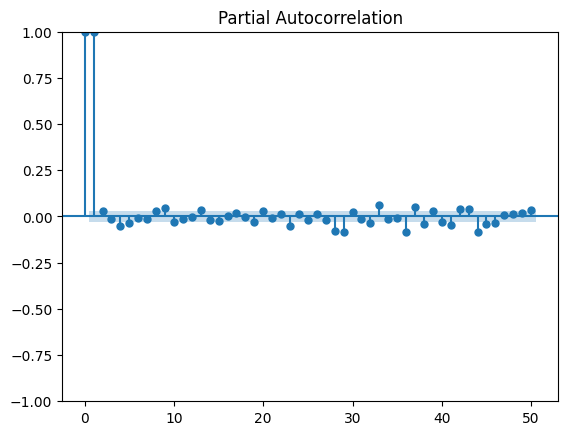

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train_data['close'].values, lags=50);

In [8]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(order=(4,1,4))
forecaster.fit(train_data['close'].values,fh=list(range(7)))
forecaster.summary()

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4185
Model:               SARIMAX(4, 1, 4)   Log Likelihood              -32746.872
Date:                Wed, 05 Oct 2022   AIC                          65513.743
Time:                        10:56:48   BIC                          65577.133
Sample:                             0   HQIC                         65536.162
                               - 4185                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.4098     39.079      0.292      0.770     -65.184      88.004
ar.L1         -0.9494      0.033    -28.600      0.000      -1.014      -0.884
ar.L2         -0.3260      0.009    -34.774      0.000      -0.344      -0.308
ar.L3         -1.0559      0.009   -111.610      0.000      -1.074      -1.037
ar.L4         -0.8511      0.032    -26.623      0.000      -0.914      -0.788
ma.L1          0.9062      0.037     24.767      0.000       0.834       0.978
ma.L2          0.2944      0.010     30.648      0.000       0.276       0.313
ma.L3          1.0410      0.010    102.309      0.000       1.021       1.061
ma.L4          0.8259      0.035     23.301      0.000       0.756       0.895
sigma2      3.694e+05   2154.485    171.451      0.000    3.65e+05    3.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            184050.35
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):            1481.81   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np
test_data = test_df['close'].values.tolist()
windows = np.lib.stride_tricks.sliding_window_view(test_data,7)
lm = LinearRegression(fit_intercept=False)
forecasts = []
for idx,window in enumerate(windows):
    forecast = forecaster.predict()

    scaled = (forecast - forecast[0]) / np.std(forecast)
    lm.fit(np.array(list(range(len(scaled)))).reshape(-1, 1), scaled)

    forecasts.append(lm.coef_[0])

    forecaster.reset()
    forecaster.fit(np.array(test_data+list(window)),fh=list(range(7)))

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters

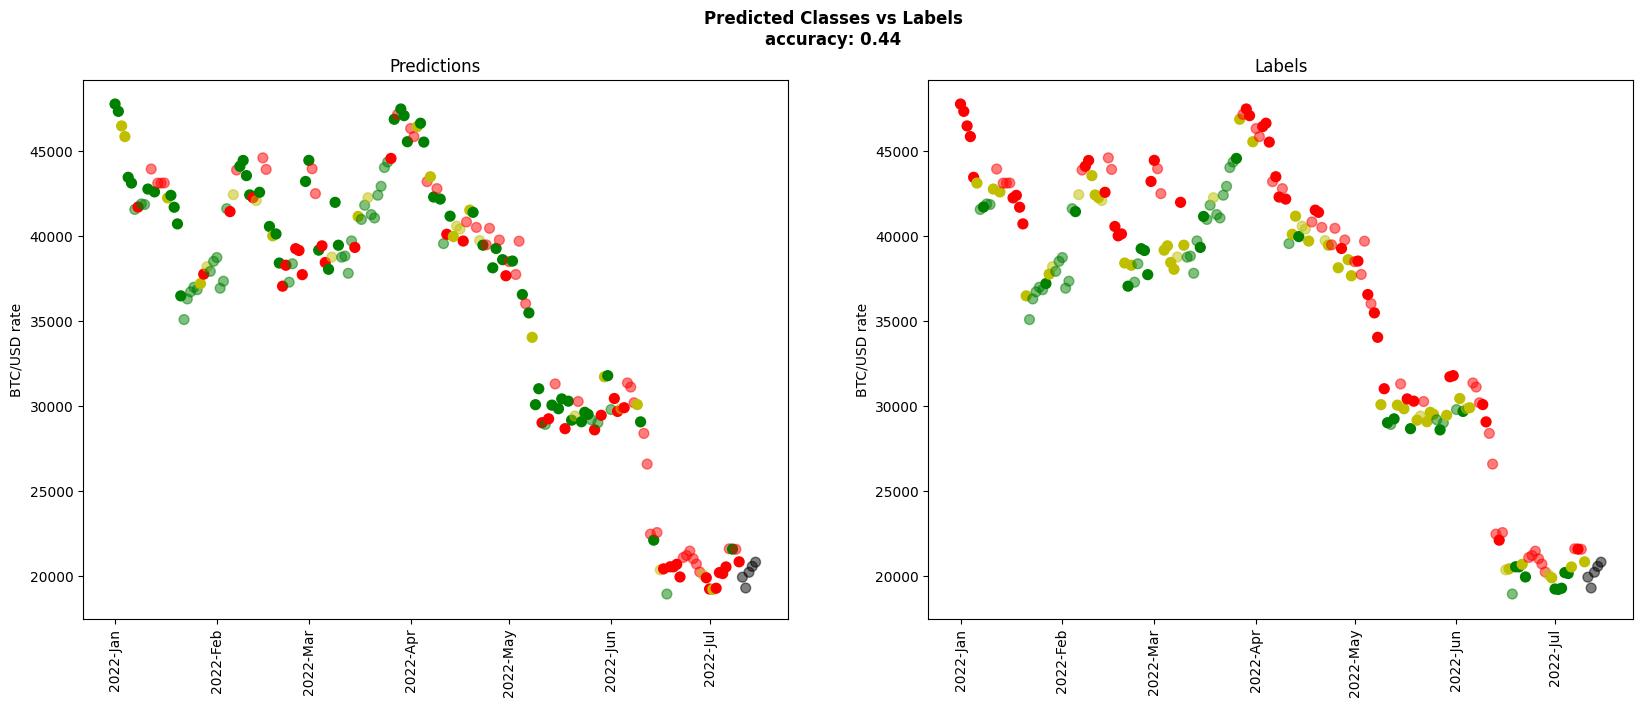

In [40]:
import os
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import evaluation
import importlib
importlib.reload(evaluation)
lm = LinearRegression(fit_intercept=False)

classifier = lambda value : 0 if value <-0.2 else 1 if value <= 0.2 else 2

def reg_classifier(window):

    if np.std(window) == 0:
        return 1
    scaled = (window - window[0]) / np.std(window)
    lm.fit(np.array(list(range(len(scaled)))).reshape(-1, 1), scaled)

    return classifier(lm.coef_[0])


y_true = np.array(list(map(reg_classifier,windows)))
y_pred = np.array(list(map(classifier,forecasts)))

# y_true = np.reshape(y_true,(len(y_true),1))
# y_pred = np.reshape(y_pred,(len(y_pred),1))

colors, pred_colors, true_colors = evaluation._get_prediction_colors(y_pred, y_true, banned_indices=list(range(len(y_pred),len(y_pred)-7,-1)), test_data=test_df.iloc[:-7])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
diffs = np.abs(y_pred - y_true)
acc = 1 - int(np.count_nonzero(diffs)) / int(len(y_pred))
plt.suptitle(f'Predicted Classes vs Labels\naccuracy: {round(acc, 2)}', fontweight="bold")
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 12, 1)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.tick_params(axis='x', labelrotation=90)

axes[0].scatter(test_df['time'].iloc[:-7], test_df["close"].iloc[:-7], c=pred_colors, s=50)
axes[0].set_title('Predictions')
axes[0].set_ylabel('BTC/USD rate')

axes[1].scatter(test_df['time'].iloc[:-7], test_df["close"].iloc[:-7], c=true_colors, s=50)
axes[1].set_title('Labels')
axes[1].set_ylabel('BTC/USD rate')


training_dir = os.path.join('..', 'trainings', 'arima')
plt.savefig(os.path.join(training_dir,'comparison.png'))